# Comparing Networks

In this notebook, we want to compare different network to each other.
This focuses on...

- Generator Feature Unlearning*$^1$

There will be a notebook for every approx. MU algorithm

*$^1$ GeFeU: The implemented algorithm is not the same as the one in the paper. While the paper focused on unlearning specific classes, we are training to unlearn a subset of a class, tied together by a feature, which distinguish it from the rest.

### ! Make sure that Trained, Exact, Untrained Model types are trained !

In [1]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
from PIL import Image
import numpy as np

from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet

from helper import load_models_dict

USED_DATASET = "cmnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = False# <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= True,
    test = False,
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'


906

In [2]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

In [3]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    untrained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    untrained_showcase_all = ConvNet()
name = str(untrained_showcase_all)
untrained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained",
        map_location=DEVICE,
        weights_only=True,
        )
    )
untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model


In [4]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    trained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    trained_showcase_all = ConvNet()
name = str(trained_showcase_all)
trained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [5]:
trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Exact Model

In [6]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    exact_showcase = TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    exact_showcase = ConvNet()
name = str(exact_showcase)
exact_showcase.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [7]:
exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

### Generator Feature Unlearning

In [8]:
from unlearning import unlearn_n_models, GeneratorFeatureUnlearning
from training import save_model

In [9]:
# Train a single model first
if not ALLREADY_TRAINED:
    fefu = GeneratorFeatureUnlearning(
        model=trained_showcase_all,
        dataset_name=USED_DATASET,
    )
    mu_showcase = fefu.unlearn(logs=True)
    save_model(mu_showcase, name="mu_showcase", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}FEFU", logs=False)
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        mu_showcase= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        mu_showcase= ConvNet()
    name = str(mu_showcase)
    mu_showcase.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}FEFU{os.sep}{name}_mu_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

Baseline Performance
Time: 0.053357839584350586
Epoch: 1, Loss: 340.6929626464844
Epoch: 2, Loss: 102.86424255371094
Epoch: 3, Loss: 28.30641746520996
Epoch: 4, Loss: -2.618332624435425
Epoch: 5, Loss: -13.2011137008667
Epoch: 6, Loss: -17.457965850830078
Epoch: 7, Loss: -19.327425003051758
Ending Noise Maximazation Phase
Time: 11.48009181022644
______
Starting Impairing Phase
Time: 11.507347822189331
Train loss 1: 20.819023912669692
Ending Impairing Phase
Time: 16.94444990158081
Train loss 1: 18.443542271298547
Ending Repairing Phase
Time: 19.13317584991455
______


In [10]:
if not ALLREADY_TRAINED:
    mu_ms = unlearn_n_models(
        models=trained_ms,
        unlearned_data=unlearned_data,
        dataset_name=USED_DATASET,
        which_unlearning="GeneratorFeatureUnlearning",
        logs=True,
    )
    for i, model in mu_ms.items():
        save_model(model=model, name=f"{i}_mu", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}FEFU{os.sep}test_ensemble", logs=False)

else:
    mu_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}FEFU{os.sep}test_ensemble")

Unlearning 30 models trained on cmnist
Unlearned model  1/30...
Unlearned model  2/30...
Unlearned model  3/30...
Unlearned model  4/30...
Unlearned model  5/30...
Unlearned model  6/30...
Unlearned model  7/30...
Unlearned model  8/30...
Unlearned model  9/30...
Unlearned model 10/30...
Unlearned model 11/30...
Unlearned model 12/30...
Unlearned model 13/30...
Unlearned model 14/30...
Unlearned model 15/30...
Unlearned model 16/30...
Unlearned model 17/30...
Unlearned model 18/30...
Unlearned model 19/30...
Unlearned model 20/30...
Unlearned model 21/30...
Unlearned model 22/30...
Unlearned model 23/30...
Unlearned model 24/30...
Unlearned model 25/30...
Unlearned model 26/30...
Unlearned model 27/30...
Unlearned model 28/30...
Unlearned model 29/30...
Unlearned model 30/30...


___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [11]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Untrained to ...

In [12]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

36.37851738979419

In [13]:
# ...unlearned model
a12 = calc_mutlimodel_metric_average(untrained_ms, mu_ms, metric="l2_norm")
a12

198.4427866940697

In [14]:
# ...exact model
a13 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a13

36.80754758268595

#### Trained to ...

In [15]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, mu_ms, metric="l2_norm")
a21

196.58373748461406

In [16]:
# ...exact model
a22 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a22

38.481178574760754

### GeFeU to...

In [17]:
# ...exact model
a31 = calc_mutlimodel_metric_average(mu_ms, exact_ms, metric="l2_norm")
a31

200.56920317808786

#### Exact to ...

In [18]:
# see above

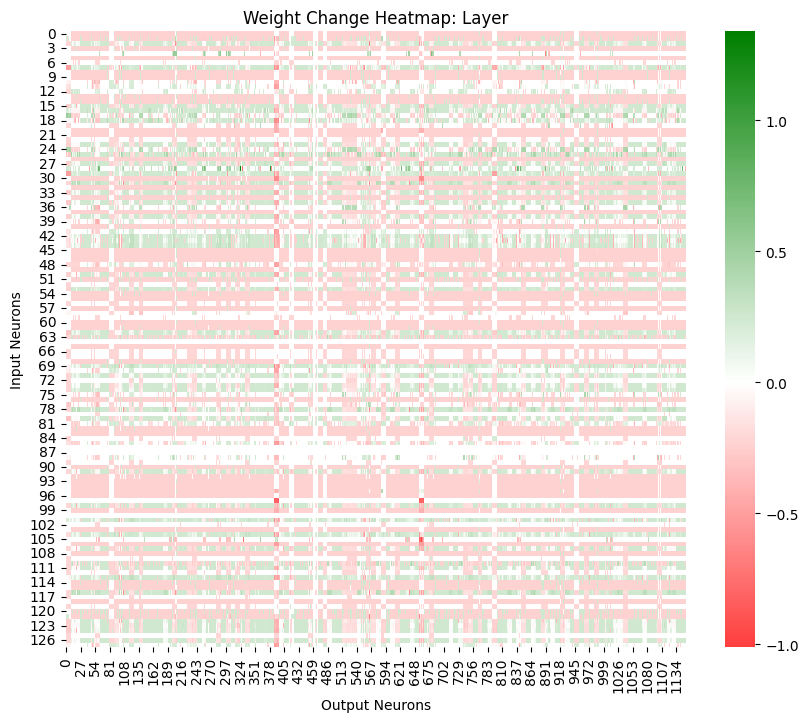

In [19]:
from visualize import visualize_weight_change

visualize_weight_change(weights_before=trained_ms[1].fc1.weight, weights_after=mu_ms[1].fc1.weight)

### Layer-wise Distance

In [20]:
from metrics import model_layer_wise_difference
lw_dist = {}
for t, mu in zip(trained_ms.values(), mu_ms.values()):
    new = model_layer_wise_difference(t, mu)
    if len(lw_dist) == 0:
        for name in new.keys():
            lw_dist[name] = []
    for name in new.keys():
        lw_dist[name].append(new[name])
for key in lw_dist.keys():
    lw_dist[key] = sum(lw_dist[key])/len(lw_dist[key])
lw_dist

{'conv1.weight': 189.45836944580077,
 'conv1.bias': 9.2096097946167,
 'conv2.weight': 4205.808097330729,
 'conv2.bias': 17.187580140431724,
 'conv3.weight': 16124.09375,
 'conv3.bias': 41.81796023050944,
 'fc1.weight': 22779.7830078125,
 'fc1.bias': 35.49844888051351,
 'fc2.weight': 274.3514216105143,
 'fc2.bias': 1.421541220943133}

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [21]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [22]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.0534550683583781

#### Trained to...

In [23]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

5.849420932972291

#### Exact ...

In [24]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

7.33146701306976

#### MU to...

In [25]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.19658136144933994

In [26]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.922625047090458

In [27]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.019217999074717

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [28]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.1001 - Standard Deviation for D_gesamt: 0.0621


Average Accuracy for D_remain: 0.0971 - Standard Deviation for D_remain: 0.0613


Average Accuracy for 0: 0.0092 - Standard Deviation for 0: 0.0496


Average Accuracy for 1: 0.0200 - Standard Deviation for 1: 0.1075


Average Accuracy for 2: 0.0217 - Standard Deviation for 2: 0.1170


Average Accuracy for 3: 0.0014 - Standard Deviation for 3: 0.0073


Average Accuracy for 4: 0.0147 - Standard Deviation for 4: 0.0791


Average Accuracy for 5: 0.8794 - Standard Deviation for 5: 0.3134


Average Accuracy for 6: 0.0027 - Standard Deviation for 6: 0.0147


Average Accuracy for 8: 0.0164 - Standard Deviation for 8: 0.0884


Average Accuracy for 9: 0.0183 - Standard Deviation for 9: 0.0987


Average Accuracy for 7_all: 0.1261 - Standard Deviation for 7_all: 0.3232


Average Accuracy for 7_remain: 0.1262 - Standard Deviation for 7_remain: 0.3235


Average Accuracy for 7_erased: 0.1260 - Standard Deviation for 7_erased: 0.3232
plotting...


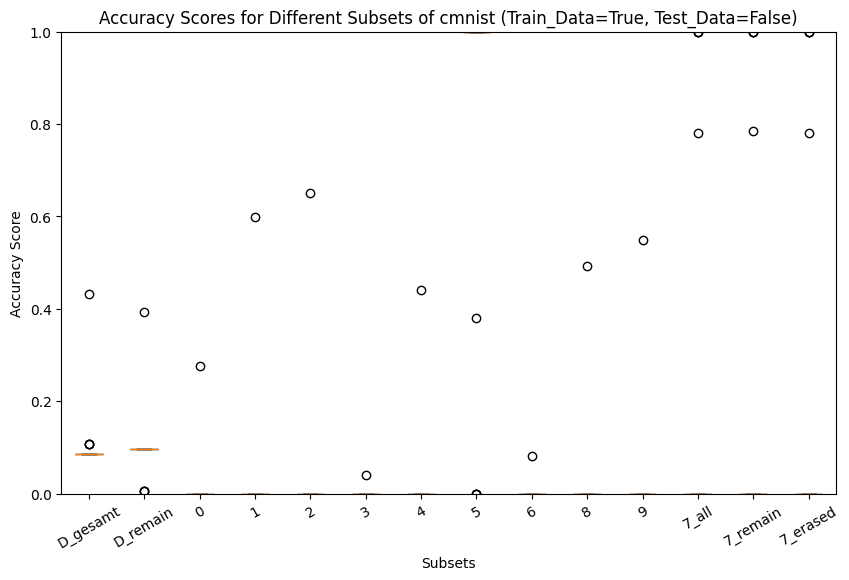

In [29]:
accs["mu_ms_train"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.1017 - Standard Deviation for D_gesamt: 0.0599


Average Accuracy for D_remain: 0.0990 - Standard Deviation for D_remain: 0.0598


Average Accuracy for 0: 0.0088 - Standard Deviation for 0: 0.0473


Average Accuracy for 1: 0.0212 - Standard Deviation for 1: 0.1143


Average Accuracy for 2: 0.0237 - Standard Deviation for 2: 0.1275


Average Accuracy for 3: 0.0014 - Standard Deviation for 3: 0.0073


Average Accuracy for 4: 0.0153 - Standard Deviation for 4: 0.0823


Average Accuracy for 5: 0.8758 - Standard Deviation for 5: 0.3196


Average Accuracy for 6: 0.0029 - Standard Deviation for 6: 0.0157


Average Accuracy for 8: 0.0139 - Standard Deviation for 8: 0.0746


Average Accuracy for 9: 0.0156 - Standard Deviation for 9: 0.0841


Average Accuracy for 7_all: 0.1267 - Standard Deviation for 7_all: 0.3245


Average Accuracy for 7_remain: 0.1301 - Standard Deviation for 7_remain: 0.3320


Average Accuracy for 7_erased: 0.1265 - Standard Deviation for 7_erased: 0.3242
plotting...


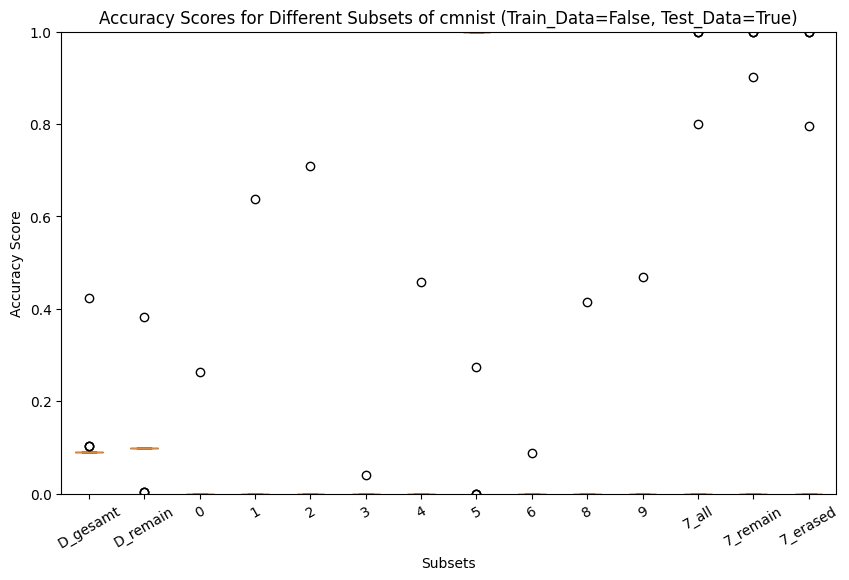

In [30]:
# can take like 80minutes
accs["mu_ms_test"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

#### Losses

In [31]:
losses = {}

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average loss for D_gesamt: 0.2861 - Standard Deviation for D_gesamt: 0.0102


Average loss for D_remain: 0.2867 - Standard Deviation for D_remain: 0.0075


Average loss for 0: 0.2882 - Standard Deviation for 0: 0.0058


Average loss for 1: 0.2839 - Standard Deviation for 1: 0.0214


Average loss for 2: 0.2954 - Standard Deviation for 2: 0.0298


Average loss for 3: 0.2868 - Standard Deviation for 3: 0.0102


Average loss for 4: 0.2862 - Standard Deviation for 4: 0.0166


Average loss for 5: 0.2877 - Standard Deviation for 5: 0.0058


Average loss for 6: 0.2900 - Standard Deviation for 6: 0.0037


Average loss for 8: 0.2868 - Standard Deviation for 8: 0.0151


Average loss for 9: 0.2848 - Standard Deviation for 9: 0.0220


Average loss for 7_all: 0.2825 - Standard Deviation for 7_all: 0.0347


Average loss for 7_remain: 0.3202 - Standard Deviation for 7_remain: 0.0462


Average loss for 7_erased: 0.2832 - Standard Deviation for 7_erased: 0.0347
plotting...


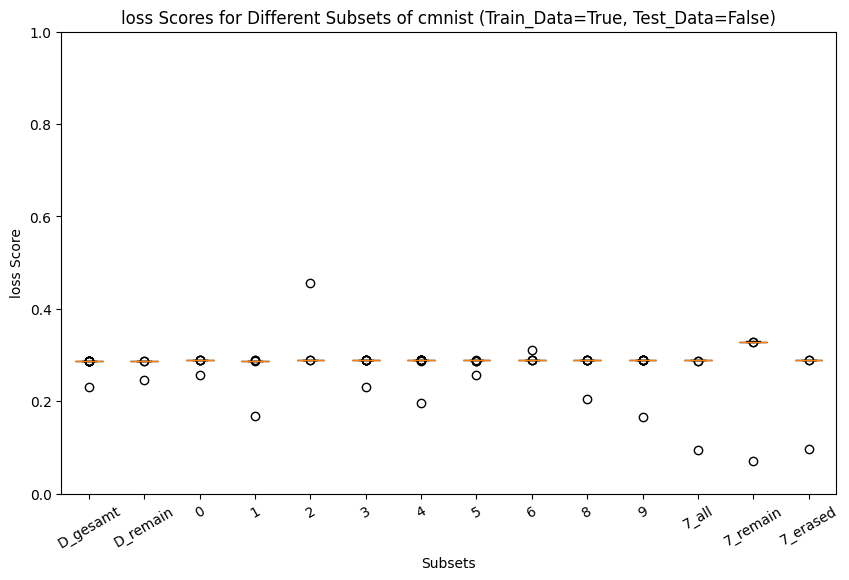

In [32]:
losses["mu_ms_train"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="loss", train_split=True, test_split=False, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average loss for D_gesamt: 0.2861 - Standard Deviation for D_gesamt: 0.0095


Average loss for D_remain: 0.2867 - Standard Deviation for D_remain: 0.0069


Average loss for 0: 0.2886 - Standard Deviation for 0: 0.0030


Average loss for 1: 0.2835 - Standard Deviation for 1: 0.0253


Average loss for 2: 0.2911 - Standard Deviation for 2: 0.0174


Average loss for 3: 0.2875 - Standard Deviation for 3: 0.0102


Average loss for 4: 0.2852 - Standard Deviation for 4: 0.0166


Average loss for 5: 0.2888 - Standard Deviation for 5: 0.0013


Average loss for 6: 0.2904 - Standard Deviation for 6: 0.0075


Average loss for 8: 0.2865 - Standard Deviation for 8: 0.0102


Average loss for 9: 0.2864 - Standard Deviation for 9: 0.0188


Average loss for 7_all: 0.2825 - Standard Deviation for 7_all: 0.0338


Average loss for 7_remain: 0.3281 - Standard Deviation for 7_remain: 0.0469


Average loss for 7_erased: 0.2829 - Standard Deviation for 7_erased: 0.0336
plotting...


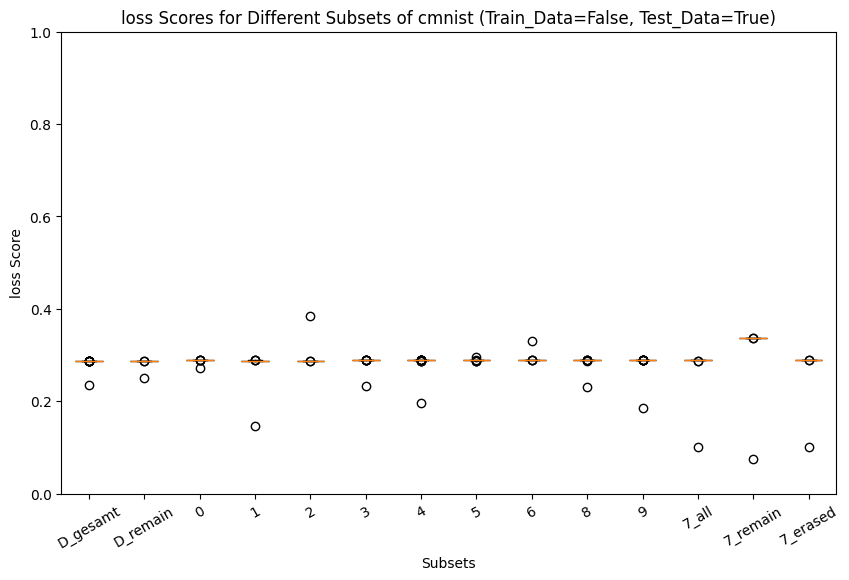

In [33]:
losses["mu_ms_test"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="loss", train_split=False, test_split=True, logs=True)